<a href="https://colab.research.google.com/github/smoralesc91/DataScience2024/blob/main/T1_mod_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [14]:
import os
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import __version__ as mpl_version
import seaborn as sns
from scipy import __version__ as sp_version
import scipy.stats as stats
from scipy.stats import norm
from sklearn.metrics import r2_score
from sklearn import __version__ as skl_version

print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)
print('matplotlib version:', mpl_version)
print('seaborn version:', sns.__version__)
print('scipy version:', sp_version)
print('sklearn version:', skl_version)

pandas version: 1.5.3
numpy version: 1.25.2
matplotlib version: 3.7.1
seaborn version: 0.13.1
scipy version: 1.11.4
sklearn version: 1.2.2


# Base de datos: Registros Geofísicos

In [40]:
url = 'https://raw.githubusercontent.com/smoralesc91/DataScience2024/main/Data/well_data_rev1.csv'
data = pd.read_csv(url)

data_units= np.array(['ft', 'in', 'API', 'ohm.m', 'b/e', 'g/cc', 'p.u.', 'adim'])

print(data_units)
print(data.head(5))

['ft' 'in' 'API' 'ohm.m' 'b/e' 'g/cc' 'p.u.' 'adim']
    DEPTH  CALI   GR  ILD  PEF   RHOB   NPHI  SHALE
0  5000.0   8.8  125  2.6  2.6  2.199  0.403      1
1  5000.5   8.8  129  2.5  2.7  2.209  0.373      1
2  5001.0   8.8  133  2.6  2.9  2.232  0.378      1
3  5001.5   8.8  142  2.8  3.1  2.268  0.386      1
4  5002.0   8.7  147  3.1  2.9  2.295  0.375      1


In [41]:
data.describe()

,DEPTH,CALI,GR,ILD,PEF,RHOB,NPHI,SHALE
count,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000
mean,5300.000000,8.644130,76.518734,25.347377,3.320733,2.550055,0.195087,0.562864
std,173.421572,1.154275,38.601229,40.978320,0.711321,0.115164,0.131611,0.496239
min,5000.000000,7.300000,15.000000,2.300000,1.800000,1.891000,0.006000,0.000000
25%,5150.000000,7.500000,31.000000,3.600000,2.900000,2.475000,0.056000,0.000000
50%,5300.000000,8.500000,97.000000,4.800000,3.200000,2.568000,0.257000,1.000000
75%,5450.000000,9.500000,108.000000,19.500000,3.700000,2.638000,0.306000,1.000000
max,5600.000000,12.200000,153.000000,165.400000,5.300000,2.773000,0.467000,1.000000


# Funciones


In [57]:
def estadistica_basica(info, log_trans = False):

  if log_trans == True:
    info = np.log10(info)
  else:
    info

  n=len(info)
  minimo=np.min(info)
  q1=np.percentile(info,25)
  mediana=np.percentile(info,50)
  media=np.mean(info)
  q3=np.percentile(info,75)
  maximo=np.max(info)
  rango=maximo-minimo
  iqr=q3-q1
  varianza=info.var()
  desviacion_estandar=np.std(info)
  coef_var = desviacion_estandar/media
  skewness=np.mean((info-media)**3)/(desviacion_estandar**3)
  k=np.mean(((info-media)/desviacion_estandar)**4)

  eb=n,minimo,q1,mediana,media,q3,maximo,rango, iqr,varianza,desviacion_estandar,coef_var,skewness, k

  etiquetas = ['No. muestras', 'Mínimo', 'Q1', 'Mediana', 'Media', 'Q3', 'Máximo', 'Rango', 'IQR', 'Varianza', 'Desviacion estándar', 'Coeficiente de variación','Simetría', 'Curtosis']

  estadistica_calculada = pd.DataFrame({'Estadígrafo': etiquetas, 'Valor Numérico': eb})
  estadistica_calculada['Valor Numérico'] = estadistica_calculada['Valor Numérico'].map('{:.2f}'.format)

  return estadistica_calculada

In [43]:
def plotxy(dx, dy, log_=False):
    # Crear una figura con 1 fila y 4 columnas
    column_headers = data.columns.tolist()
    y_column = column_headers[1]  # Porosity
    x_column = column_headers[0]  # Depth
    # Datos para la gráfica
    x_data = data[x_column]
    y_data = data[y_column]

    fig = plt.figure(figsize=(10, 10))

    # Tamaño y ubicación de los subplots utilizando subplot2grid
    ax_disp = plt.subplot2grid((7, 7), (3, 0), colspan=4, rowspan=4)
    ax_info = plt.subplot2grid((7, 7), (0, 4), colspan=3, rowspan=3)
    ax_hist_v1 = plt.subplot2grid((7, 7), (0, 0), colspan=4, rowspan=2)
    ax_box_cadmio = plt.subplot2grid((7, 7), (2, 0), colspan=4)
    ax_hist_v2 = plt.subplot2grid((7, 7), (3, 5), colspan=2, rowspan=4)
    ax_box_plomo = plt.subplot2grid((7, 7), (3, 4), rowspan=4)

    # Graficar el gráfico de dispersión
    ax_disp.scatter(dx, dy)
    ax_disp.set(xlabel=x_column, ylabel=y_column)

    # Ajustar una línea de regresión lineal en la gráfica de dispersión
    m, b = np.polyfit(dx, dy, 1)
    ax_disp.plot(dx, m * dx + b, color='red', label='Tendecy line')

    # Agregar la ecuación de la línea de regresión en el gráfico
    equation_text = f' y = {m:.2f}x + {b:.2f}'
    plt.text(0.05, 0.9, equation_text, transform=ax_disp.transAxes, fontsize=12, color='red')

    # Graficas el histograma del cadmio en la parte superior
    datos1 = dx
    n1 = len(datos1)
    k1 = 1 + int(np.log2(n1))

    ax_hist_v1.hist(datos1, bins=k1, orientation='vertical', color='skyblue', edgecolor='black')
    ax_hist_v1.set(ylabel='Frecuency')

    # Eliminar las marcas de los ejes x e y en ax_info
    ax_info.set_xticks([])
    ax_info.set_yticks([])

    # Calcular la media y la mediana
    media = np.mean(datos1)
    mediana = np.median(datos1)

    # Agregar líneas verticales para la media y la mediana en el subplot de distribución
    ax_hist_v1.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {media:.2f}')
    ax_hist_v1.axvline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Median: {mediana:.2f}')
    ax_hist_v1.legend()

    # Graficar el boxplot horizontal del cadmio en la parte superior
    sns.boxplot(x=dx, ax=ax_box_cadmio, orient='h', width=0.1)

    ax_box_cadmio.set(xticklabels=[], yticklabels=[])
    ax_box_cadmio.set_title('')


    # Graficar el histograma del plomo en la parte lateral derecha
    datos = dy
    n = len(datos)
    k = 1 + int(np.log2(n))

    ax_hist_v2.hist(datos, bins=k, orientation='horizontal', color='skyblue', edgecolor='black', log=log_)
    ax_hist_v2.set(xlabel='Frecuency')

    # Calcular la media y la mediana
    media = np.mean(datos)
    mediana = np.median(datos)

    # Agregar líneas verticales para la media y la mediana en el subplot de distribución
    ax_hist_v2.axhline(media, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {media:.2f}')
    ax_hist_v2.axhline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Median: {mediana:.2f}')
    ax_hist_v2.legend()

    # Graficar el boxplot vertical del plomo en la parte lateral derecha
    sns.boxplot(y=dy, ax=ax_box_plomo, orient='v', width=0.1)
    ax_box_plomo.set(xticklabels=[], yticklabels=[])
    ax_box_plomo.set_title('')

    # Agregar texto al gráfico
    p = dx.corr(dy)
    s = dx.corr(dy, method='spearman')
    k= dx.corr(dy, method='kendall')

    # Coeficiente de correlación R^2
    m, b = np.polyfit(dx, dy, 1)
    y_pred = m * dx + b
    r2 = r2_score(dy, y_pred)

    ax_info.text(0.2, 0.9, f'Pearson: {p:.2f}', fontsize=12, color='black')
    ax_info.text(0.2, 0.8, f'Spearman: {s:.2f}', fontsize=12, color='black')
    ax_info.text(0.2, 0.7, f'Kendall: {k:.2f}', fontsize=12, color='black')
    ax_info.text(0.2, 0.6, f'R^2: {r2:.2f}', fontsize=12, color='black')

    # Ajustar la posición de los subplots
    plt.subplots_adjust(wspace=0.5, hspace=0.6)  # Espacio entre los subplots

    # Mostrar el gráfico
    plt.show()

In [44]:
def regresion_lineal(dx,dy):
  m, b = np.polyfit(dx, dy, 1)
  y_pred = m * dx + b
  alma=dy-y_pred
  #alma= pd.DataFrame(dy-y_pred)
  return alma

def crear_graficos_estadisticos(datos):

    # Crear una figura con 1 fila y 4 columnas
    fig = plt.figure(figsize=(10, 10))

    # Tamaño y ubicación de los subplots utilizando subplot2grid
    ax_hist = plt.subplot2grid((8, 8), (0, 0), colspan=4, rowspan=4)
    ax_cdf = plt.subplot2grid((8, 8), (4, 0), colspan=4, rowspan=4)
    ax_qq = plt.subplot2grid((8, 8), (0, 4), colspan=4, rowspan=4)
    ax_pp = plt.subplot2grid((8, 8), (4, 4), colspan=4, rowspan=4)

    # Histograma de residuos
    n1 = len(datos)
    k1 = 1 + int(np.log2(n1))

    ax_hist.hist(datos, bins=k1, orientation='vertical', color='skyblue', edgecolor='black')
    ax_hist.set(ylabel='Frecuencia')
    ax_hist.set(title='Histograma')

    # Calcular la media y la mediana
    media = np.mean(datos)
    mediana = np.median(datos)

    # Agregar líneas verticales para la media y la mediana en el subplot de distribución
    ax_hist.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Media: {media:.2f}')
    ax_hist.axvline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Mediana: {mediana:.2f}')
    ax_hist.legend()

    # QQ plot
    media_ajustada, desviacion_ajustada = stats.norm.fit(datos)
    cuantiles_teoricos = stats.norm.ppf(np.linspace(0.01, 0.99, 155), loc=media_ajustada, scale=desviacion_ajustada)
    datos_ordenados = np.sort(datos)
    m, b = np.polyfit(cuantiles_teoricos, datos_ordenados, 1)

    ax_qq.scatter(cuantiles_teoricos, datos_ordenados, alpha=0.7)
    ax_qq.plot(cuantiles_teoricos, m * cuantiles_teoricos + b, color='red', label='Línea de Tendencia')
    ax_qq.set(ylabel='Cuantiles observados', xlabel='Cuantiles teóricos')
    ax_qq.set(title='Q-Q Plot')

    # CDF
    datos_ordenados = np.sort(datos)
    cdf_empirica = np.arange(1, len(datos_ordenados) + 1) / len(datos_ordenados)

    media, desviacion = norm.fit(datos)
    x = np.linspace(-200, 700, 1000)
    cdf_teorica = norm.cdf(x, loc=media, scale=desviacion)

    ax_cdf.plot(datos_ordenados, cdf_empirica, marker='o', linestyle='-', label='CDF Empírica')
    ax_cdf.plot(x, cdf_teorica, linestyle='--', color='red', label='CDF Teórica (Normal)')
    ax_cdf.set(ylabel='Cuantiles Observados', xlabel='Probabilidad Acumulada Teórica Normalizada', title='CDF Empírica vs. CDF Teórica')

    # PP plot
    datos_ordenados = np.sort(datos)
    cdf_empirica = np.arange(1, len(datos_ordenados) + 1) / len(datos_ordenados)
    media, desviacion = norm.fit(datos)
    x = np.linspace(min(datos), max(datos), 155)
    cdf_teorica = norm.cdf(x, loc=media, scale=desviacion)

    ax_pp.plot(cdf_teorica, cdf_empirica, marker='o', linestyle='', label='CDF Empírica vs. CDF Teórica')
    ax_pp.plot([0, 1], [0, 1], linestyle='--', color='red', label='Línea de Referencia (Igualdad)')
    ax_pp.set(ylabel='Probabilidad empírica', xlabel='Probabilidad teórica', title='PP plot')

    # Ajustar la posición de los subplots
    plt.subplots_adjust(wspace=2, hspace=2)  # Espacio entre los subplots

    # Mostrar el gráfico
    plt.show()


# Puntos de la tarea

1- Obtener la estadística básica: Media, varianza, mediana, cuartiles,
curtosis, Coeficiente de simetría, máximo, mínimo, coeficiente de
variación.

In [58]:
for mnemonicos in np.array(data.keys()):
    print('---------------------')
    print(mnemonicos)
    print('---------------------')
    print('---------------------')
    estadisticas = estadistica_basica(data[mnemonicos])
    print(estadisticas)
    estadisticas.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Ciencia_datos_2024/Estadigrafos/{mnemonicos}_estadigrafos.csv', index=False)


---------------------
DEPTH
---------------------
---------------------
                 Estadígrafo Valor Numérico
0               No. muestras        1201.00
1                     Mínimo        5000.00
2                         Q1        5150.00
3                    Mediana        5300.00
4                      Media        5300.00
5                         Q3        5450.00
6                     Máximo        5600.00
7                      Rango         600.00
8                        IQR         300.00
9                   Varianza       30075.04
10       Desviacion estándar         173.35
11  Coeficiente de variación           0.03
12                  Simetría           0.00
13                  Curtosis           1.80
---------------------
CALI
---------------------
---------------------
                 Estadígrafo Valor Numérico
0               No. muestras        1201.00
1                     Mínimo           7.30
2                         Q1           7.50
3                    

In [59]:
estadistica_basica(data['ILD'], log_trans=True)

,Estadígrafo,Valor Numérico
0,No. muestras,1201.00
1,Mínimo,0.36
2,Q1,0.56
3,Mediana,0.68
4,Media,0.97
5,Q3,1.29
6,Máximo,2.22
7,Rango,1.86
8,IQR,0.73
9,Varianza,0.31


In [64]:
def plot_boxplot_histogram(data, log_trans = False, log=False):

    if log_trans == True:
      data = np.log10(data)
    else:
      data

    mean_val = data.mean()
    median_val = data.median()

    n1 = len(data)
    k1 = 1 + int(np.log2(n1))

    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(7, 4), gridspec_kw={"height_ratios": (1, 8)})

    sns.boxplot(data, orient='h', ax=ax_box)

    sns.histplot(data, ax=ax_hist, bins=k1, cumulative=False, log_scale=log)

    ax_box.axvline(x=mean_val, color='r', linestyle='--', label='Media')
    ax_box.axvline(x=median_val, color='g', linestyle='--', label='Mediana')
    ax_hist.axvline(x=mean_val, color='r', linestyle='--', label='Media')
    ax_hist.axvline(x=median_val, color='g', linestyle='--', label='Mediana')

    ax_hist.set_ylabel('Frecuencia', fontsize=14)

    if log_trans == True:
      ax_hist.set_xlabel('log' + data.name, fontsize=14)
    else:
      ax_hist.set_xlabel(data.name, fontsize=14)

    plt.tight_layout()

    ax_hist.legend()

    #plt.show()

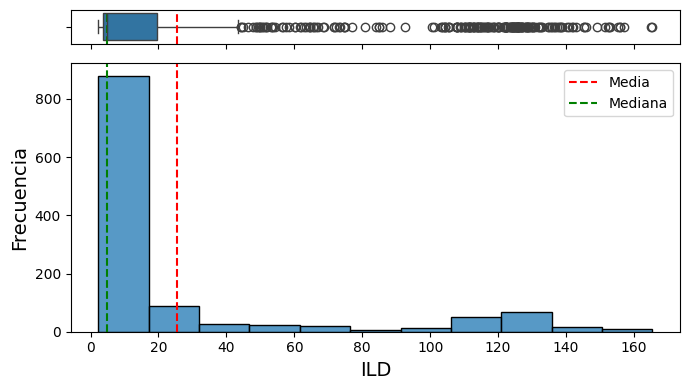

In [65]:
plot_boxplot_histogram(data['ILD'], log_trans=False)

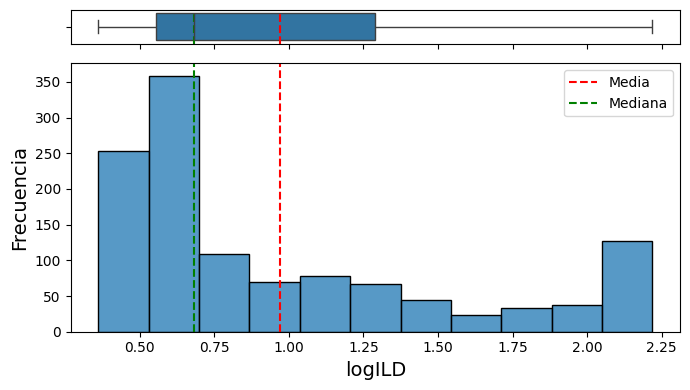

In [66]:
plot_boxplot_histogram(data['ILD'], log_trans=True)

---------------------
DEPTH
---------------------
None


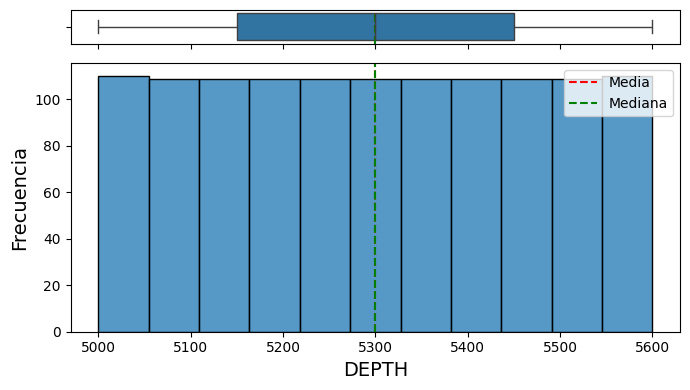

---------------------
CALI
---------------------
None


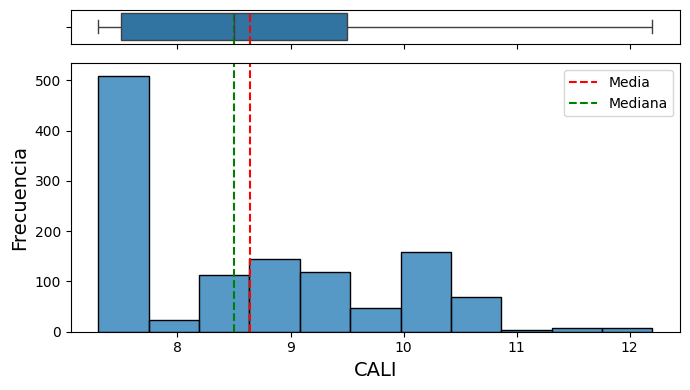

---------------------
GR
---------------------
None


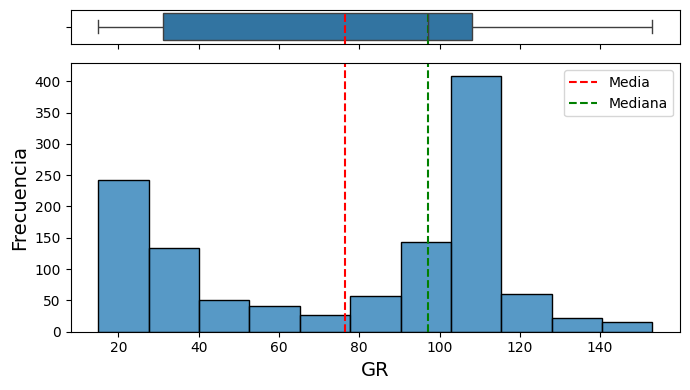

---------------------
ILD
---------------------
None


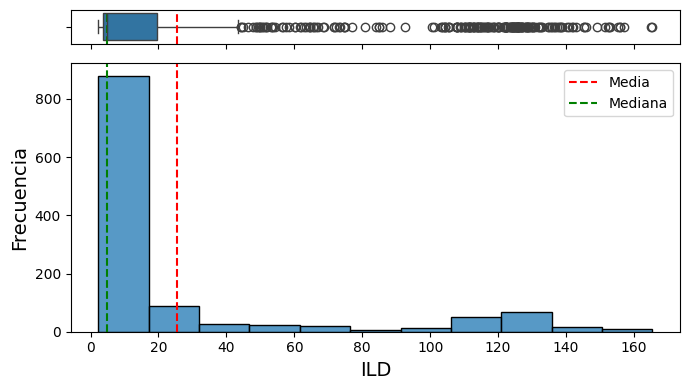

---------------------
PEF
---------------------
None


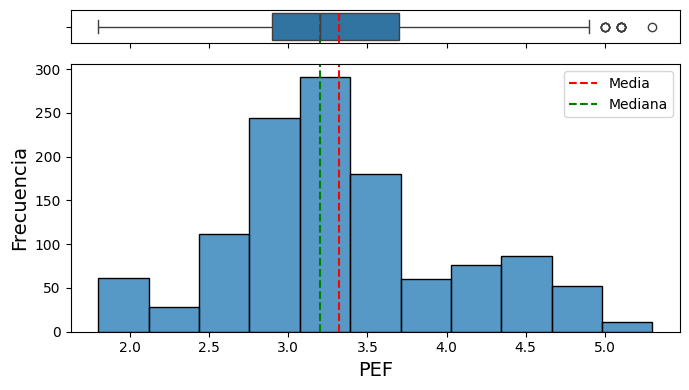

---------------------
RHOB
---------------------
None


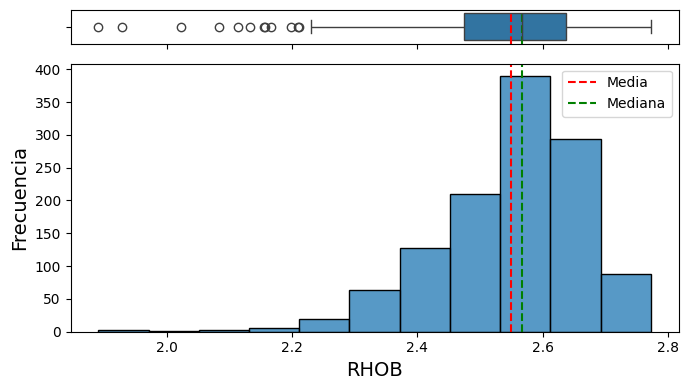

---------------------
NPHI
---------------------
None


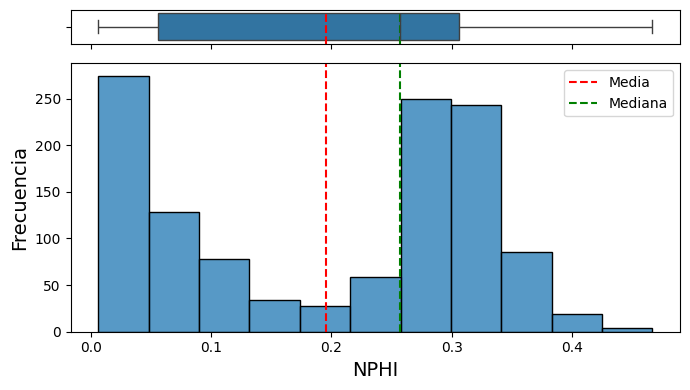

---------------------
SHALE
---------------------
None


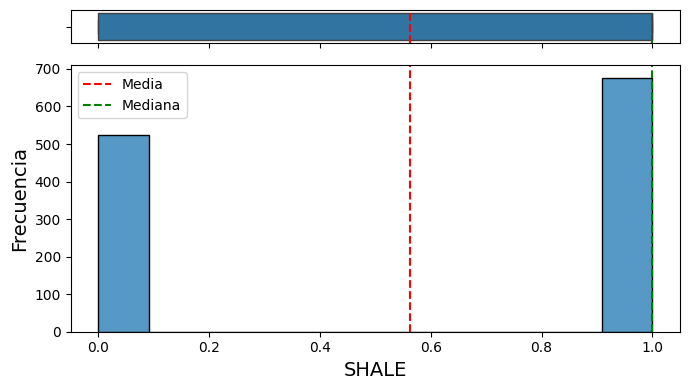

In [53]:
for mnemonicos in np.array(data.keys()):
    print('---------------------')
    print(mnemonicos)
    print('---------------------')
    print(plot_boxplot_histogram(data[mnemonicos]))
    plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/Ciencia_datos_2024/Histogramas/{mnemonicos}_estadigrafos.png', dpi=600)
    plt.show()

In [ ]:
def outliers_iqr(data, rgp):
  quartil1 = data[rgp].quantile(0.25)
  quartil3 = data[rgp].quantile(0.75)

  iqr = quartil3 - quartil1

  upper_limit = quartil3 + 1.5 * iqr
  lower_limit = quartil1 - 1.5 * iqr

  new_data_cap = data.copy()
  new_data_cap[rgp] = np.where(new_data_cap[rgp] > upper_limit, upper_limit,
                               np.where(new_data_cap[rgp] < lower_limit,lower_limit,
                                        new_data_cap[rgp]))

  plot_boxplot_histogram(data[rgp])
  plot_boxplot_histogram(new_data_cap[rgp])

  return new_data_cap

                 Estadígrafo  Valor Numérico
0               No. muestras     1201.000000
1                     Mínimo        2.230500
2                         Q1        2.475000
3                    Mediana        2.568000
4                      Media        2.551298
5                         Q3        2.638000
6                     Máximo        2.773000
7                      Rango        0.542500
8                        IQR        0.163000
9                   Varianza        0.012207
10       Desviacion estándar        0.110439
11  Coeficiente de variación        0.043288
12                  Simetría       -0.673786
13                  Curtosis        2.961596
                 Estadígrafo  Valor Numérico
0               No. muestras     1201.000000
1                     Mínimo        1.891000
2                         Q1        2.475000
3                    Mediana        2.568000
4                      Media        2.550055
5                         Q3        2.638000
6         

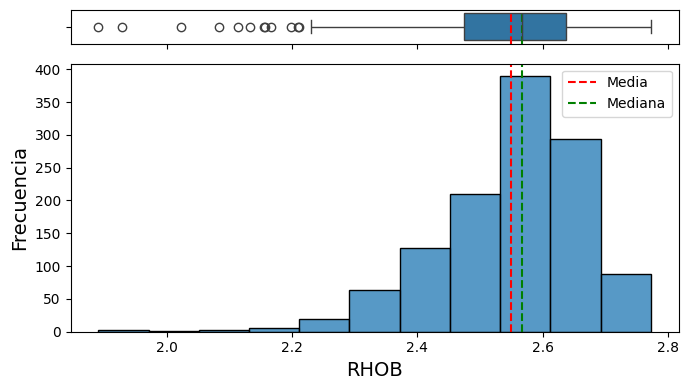

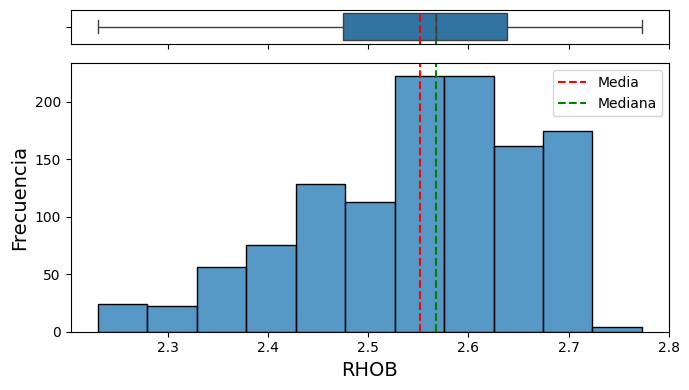

In [ ]:
new_data_outliers = outliers_iqr(data, rgp='RHOB')

print(estadistica_basica(new_data_outliers['RHOB']))
print(estadistica_basica(data['RHOB']))

In [54]:
def identify_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

def plot_with_outliers(data):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(np.arange(len(data)), data, alpha=0.7)
    outliers = identify_outliers(data)
    if not outliers.empty:
        ax.scatter(np.arange(len(outliers)), outliers, color='r', alpha=0.7, label='Outliers')
    ax.set_title(f'Plot with Outliers: {data.name}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    if not outliers.empty:
        ax.legend()
    plt.tight_layout()
    plt.show()

------------------------------
DEPTH
------------------------------
Outliers for DEPTH:
Series([], Name: DEPTH, dtype: float64)


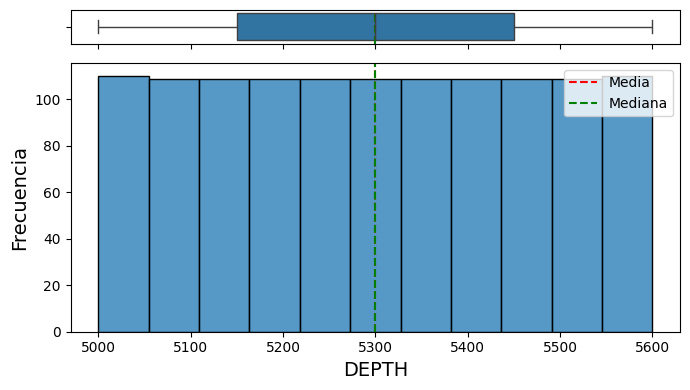

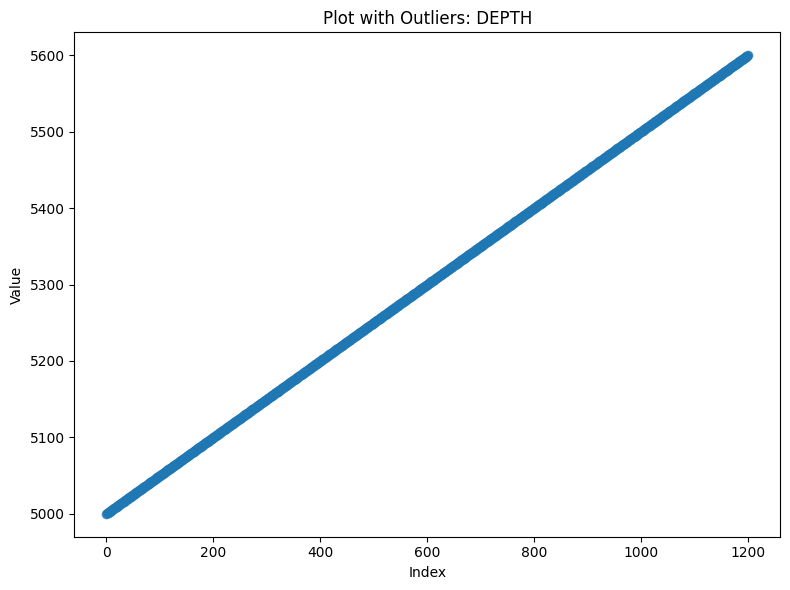

------------------------------
CALI
------------------------------
Outliers for CALI:
Series([], Name: CALI, dtype: float64)


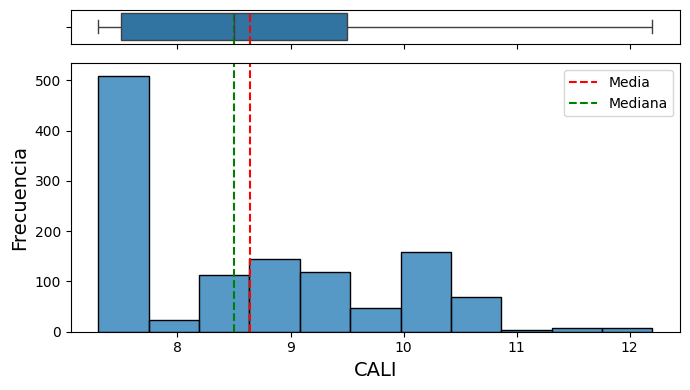

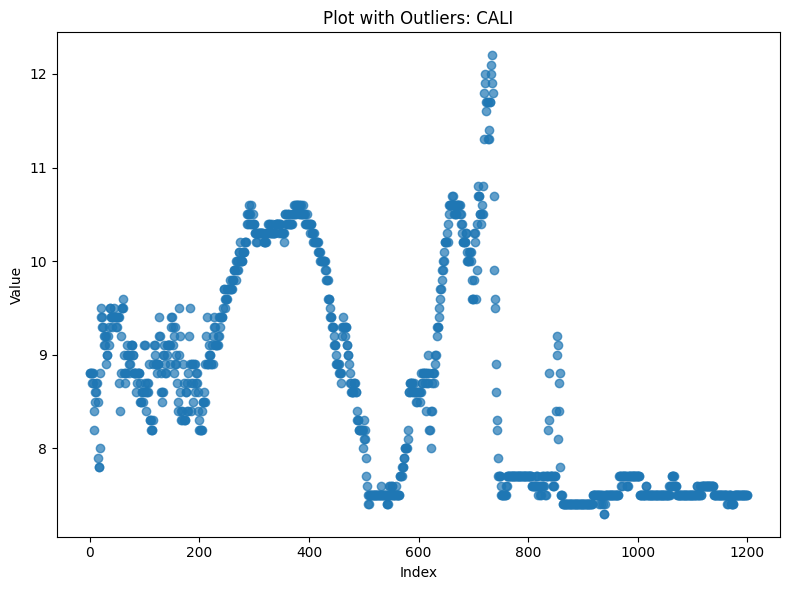

------------------------------
GR
------------------------------
Outliers for GR:
Series([], Name: GR, dtype: int64)


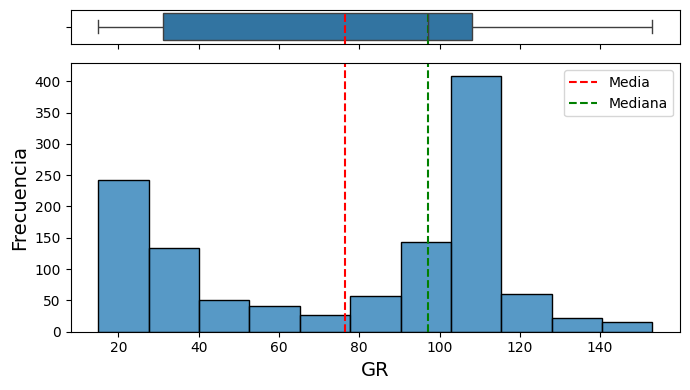

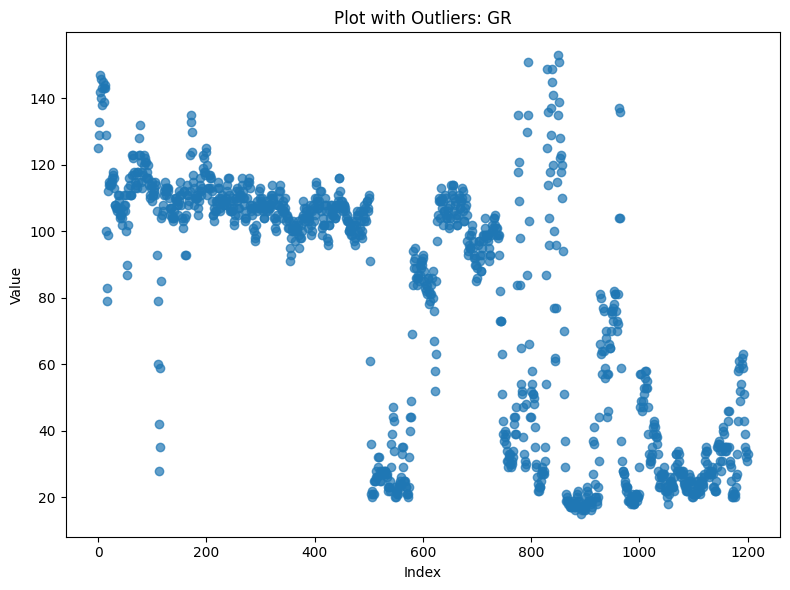

------------------------------
ILD
------------------------------
Outliers for ILD:
951     44.3
952     53.6
953     62.0
954     63.5
955     62.9
        ... 
1196    64.6
1197    68.5
1198    71.8
1199    73.3
1200    74.6
Name: ILD, Length: 212, dtype: float64


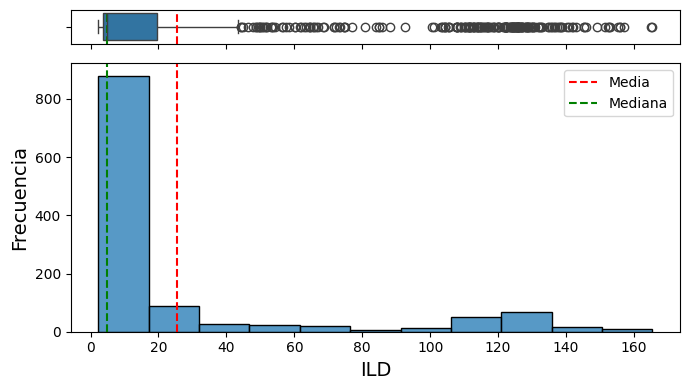

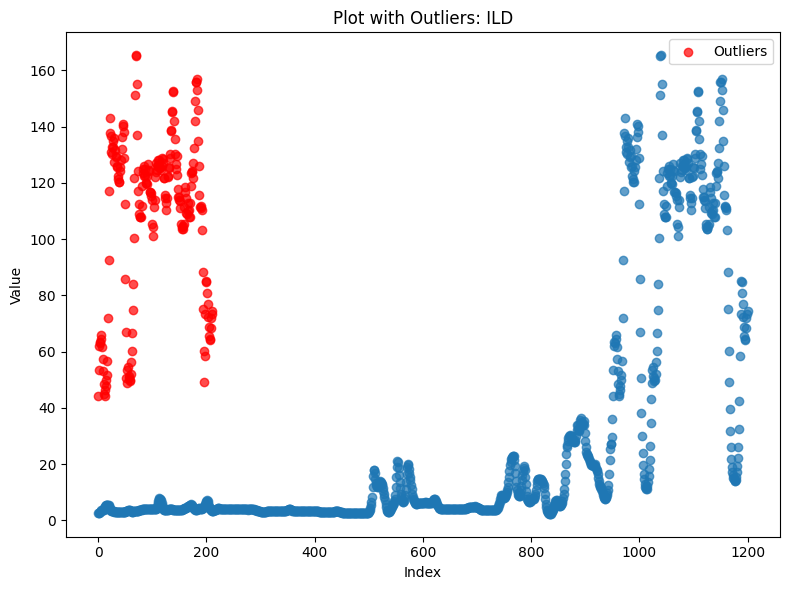

------------------------------
PEF
------------------------------
Outliers for PEF:
113     5.1
980     5.0
981     5.3
982     5.1
986     5.1
1037    5.0
1038    5.1
1039    5.1
1178    5.0
1187    5.1
1200    5.0
Name: PEF, dtype: float64


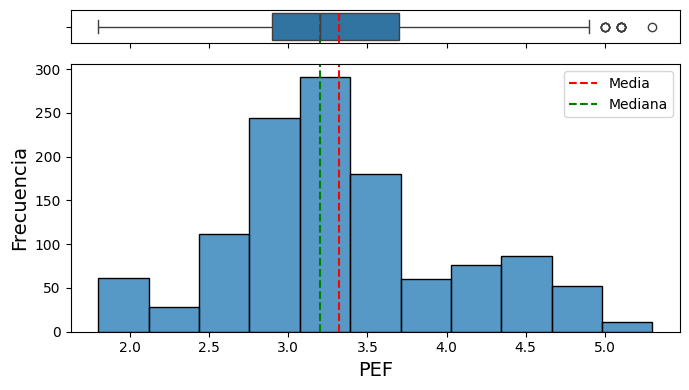

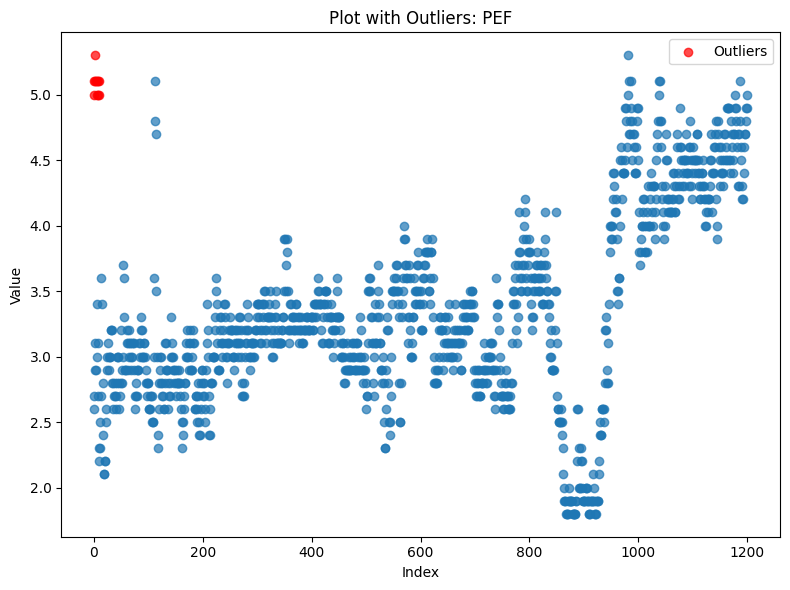

------------------------------
RHOB
------------------------------
Outliers for RHOB:
0      2.199
1      2.209
17     2.023
18     1.891
19     1.929
20     2.167
116    2.212
117    2.114
118    2.157
161    2.155
162    2.084
163    2.133
Name: RHOB, dtype: float64


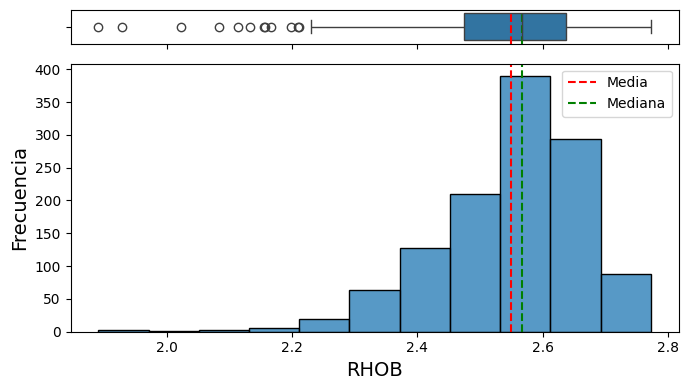

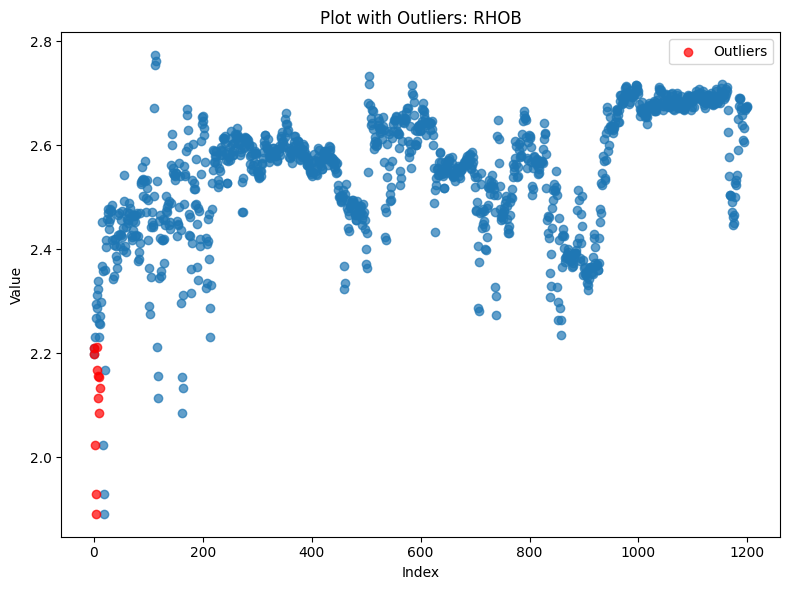

------------------------------
NPHI
------------------------------
Outliers for NPHI:
Series([], Name: NPHI, dtype: float64)


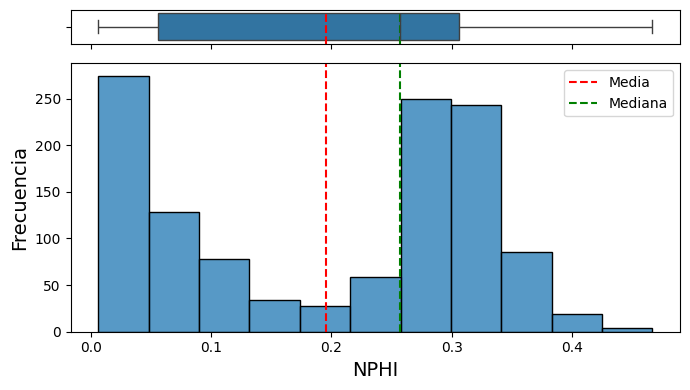

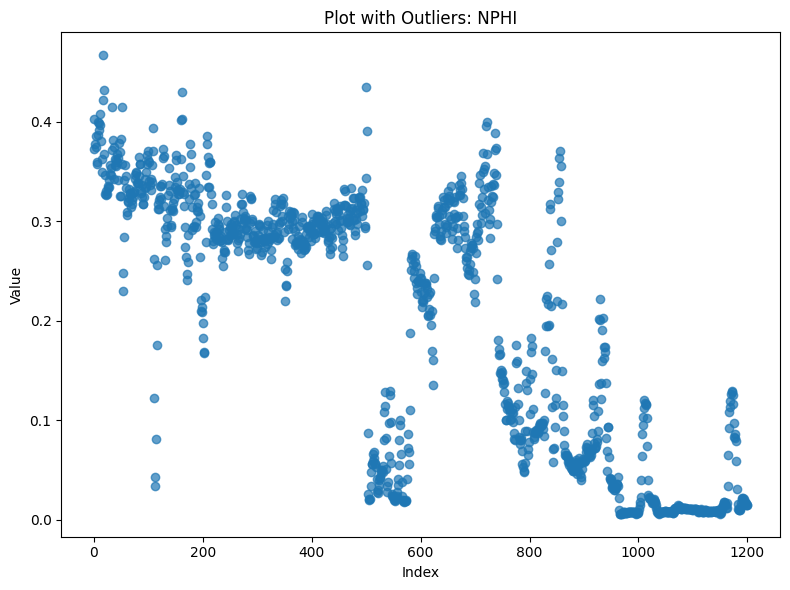

------------------------------
SHALE
------------------------------
Outliers for SHALE:
Series([], Name: SHALE, dtype: int64)


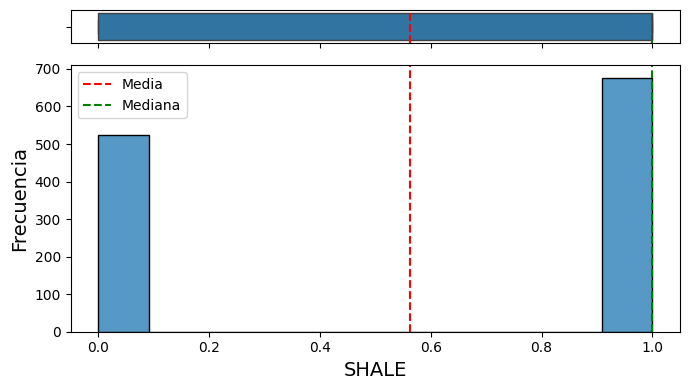

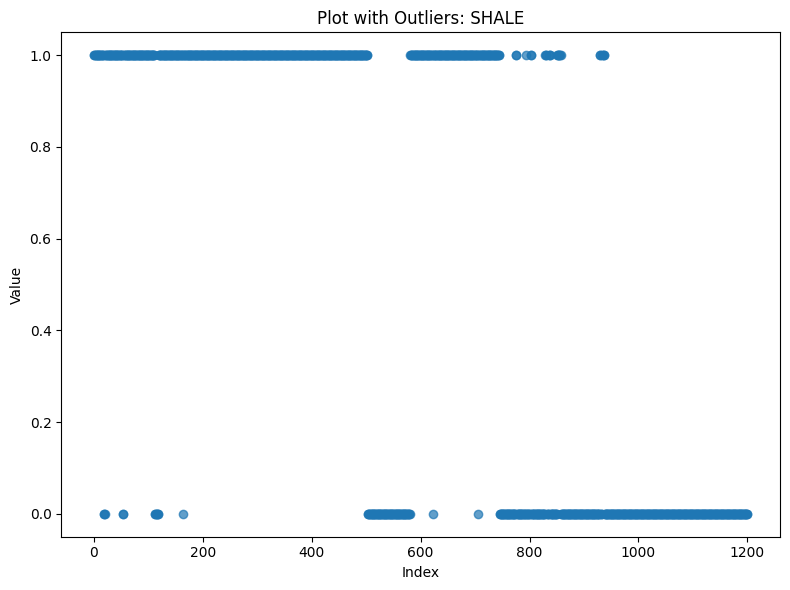

In [56]:
for mnemonicos in np.array(data.keys()):
    print('-' * 30)
    print(mnemonicos)
    print('-' * 30)
    plot_boxplot_histogram(data[mnemonicos])
    #plot_qq(data[mnemonicos])
    outliers = identify_outliers(data[mnemonicos])
    print(f"Outliers for {mnemonicos}:\n{outliers}")
    plot_with_outliers(data[mnemonicos])

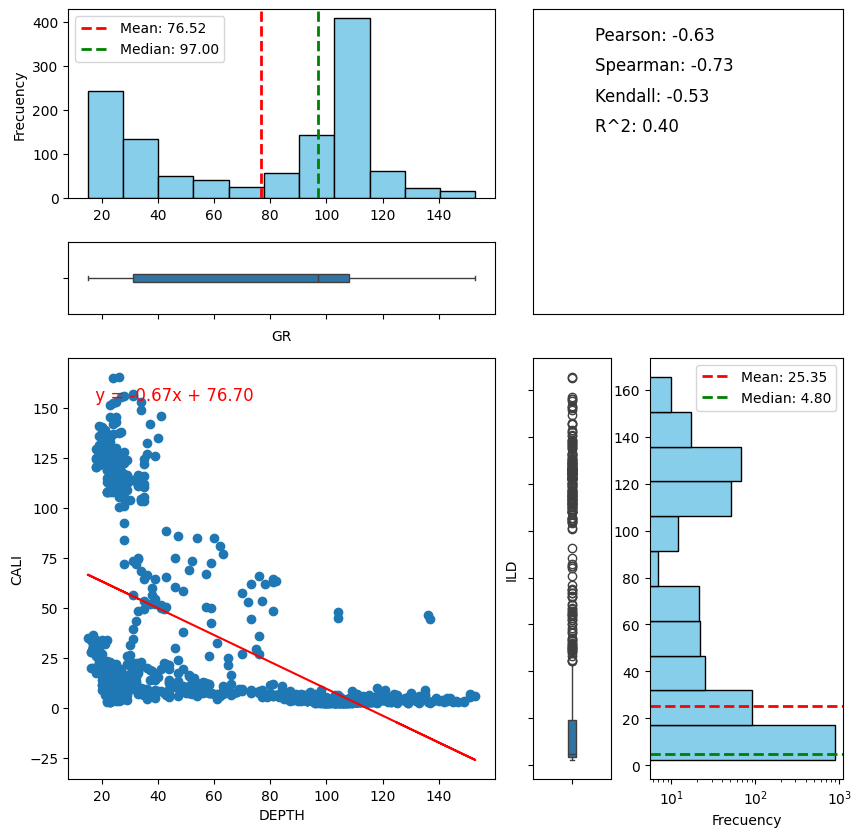

In [ ]:
plotxy(data.GR, data.ILD, log_=True)

In [ ]:
rl=regresion_lineal(df.GR, df.PEF)

In [ ]:
data.PEF

0       2.6
1       2.7
2       2.9
3       3.1
4       2.9
       ... 
1196    4.7
1197    4.9
1198    4.8
1199    4.9
1200    5.0
Name: PEF, Length: 1201, dtype: float64

TypeError: expected x and y to have same length

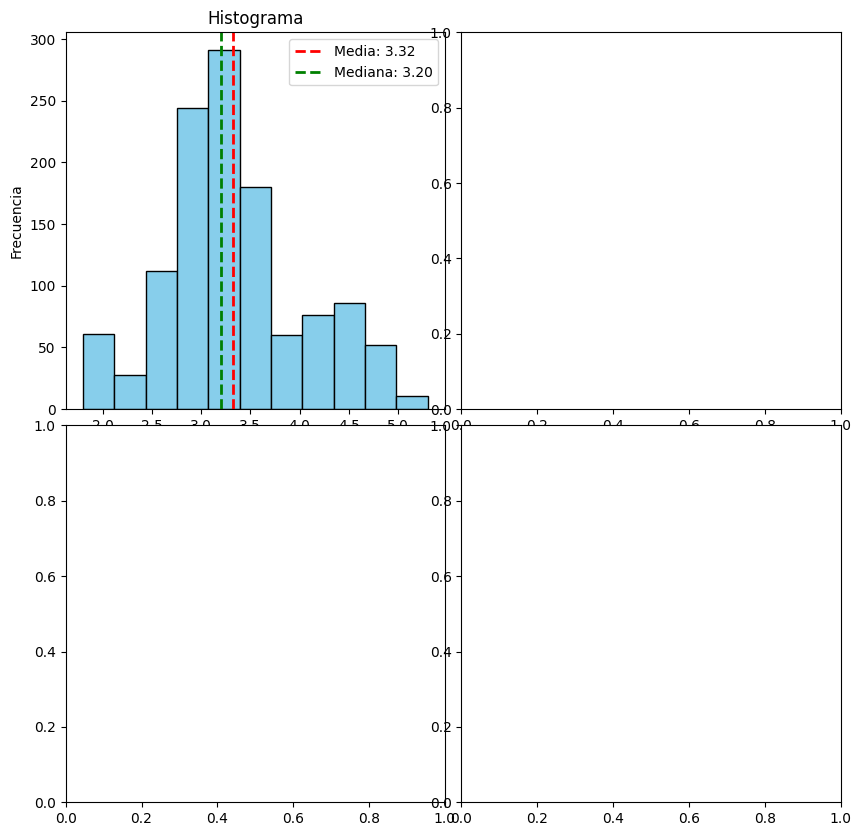

In [ ]:
crear_graficos_estadisticos(data.PEF)